<a href="https://colab.research.google.com/github/pdh21/OCF_PVmapper/blob/main/DeepNet_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://avatars.githubusercontent.com/u/48357542?s=200&v=4)

## PV mapping Example:
[Peter Hurley](http://pdh21.github.io/) 

In this notebook, we will give a simple example of training a deep net to detect solar panels from remote sensing data. 

As with most neural net projects, we need to:
1. Define training data: input tensors and target tensors. (see this [notebook](https://github.com/pdh21/OCF_PVmapper/blob/main/Example_DeepNet.ipynb) to follow converting cutouts to Tensorflow record format)
2. Define a network of layers (or model ) that maps inputs to targets.
3. Configure the learning process by choosing a loss function, an optimizer
some metrics to monitor.
4. Iterate on training data by calling the fit() method of your model.

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
cd gdrive/MyDrive/PVmapping/

/content/gdrive/MyDrive/PVmapping


In [17]:
ls

cutouts/  cutouts_tfrecords/  OCF_PVmapping_doc.gdoc


In [4]:
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

## 
#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

FILE_PATTERN='./*aerial*.tif'
OUTPUT = './cutouts_tfrecords/'  # prefix for output file names
TARGET_SIZE = [75,75]

SHARDS = 16


Tensorflow version 2.4.1
Running on TPU  ['10.6.29.58:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.6.29.58:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.6.29.58:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


## Read  from TFRecord Dataset

In [10]:
def read_tfrecord(example):
    features = {
        "image_aerial": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "image_binary": tf.io.FixedLenFeature([], tf.string),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "num":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers

    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    
    label  = example['label']
    num = example['num']
    height = example['size'][0]
    width  = example['size'][1]

    image_aerial = tf.image.decode_png(example['image_aerial'],channels=3)
    image_aerial = tf.reshape(image_aerial, [*TARGET_SIZE, 3])
    image_binary = tf.image.decode_png(example['image_binary'],channels=1)
    image_binary = tf.reshape(image_binary, [*TARGET_SIZE, 1])
    
    

    return image_aerial,image_binary, label, num, height, width
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False



In [12]:
batch_size = 16 * tpu_strategy.num_replicas_in_sync

validation_split = 0.19
filenames = tf.io.gfile.glob(OUTPUT + "*.tfrec")
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]

In [13]:
def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  records = records.with_options(option_no_order)
  return records.map(read_tfrecord, num_parallel_calls=AUTO)

In [14]:
train_dataset = load_dataset(train_fns).batch(batch_size).prefetch(AUTO)
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

In [18]:
def display_9_images_from_dataset(dataset):
  fig,axes=plt.subplots(9,2,figsize=(10,30))
  for i, (image_aerial,image_binary,label,num, height, width) in enumerate(dataset):
    axes[i,0].imshow(image_aerial.numpy().astype(np.uint8))
    axes[i,1].imshow(image_binary.numpy().astype(np.uint8)[:,:,0])
    axes[i,0].set_title(label.numpy().decode("utf-8")+' '+num, fontsize=16)
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

UnimplementedError: ignored

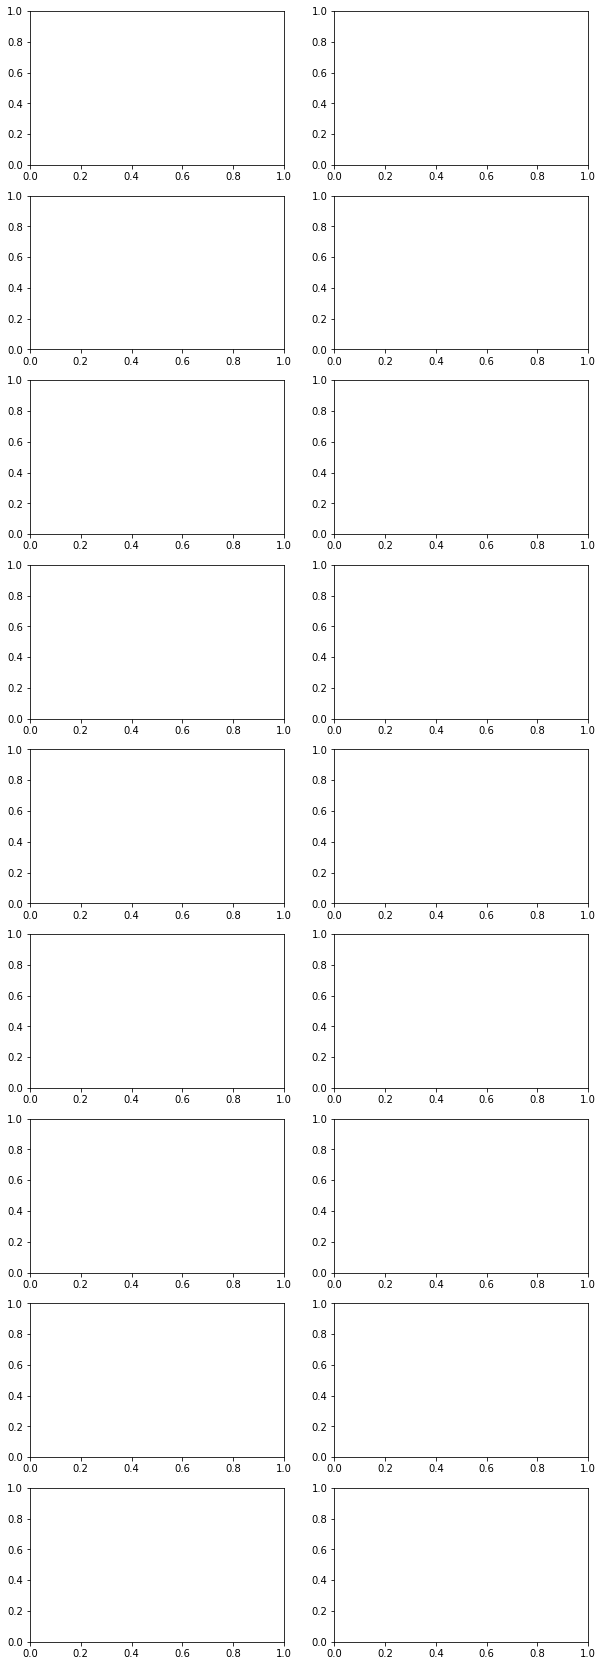

In [19]:
display_9_images_from_dataset(train_dataset)